# Levelling Up
This code demonstrates new forms of fairness that 'level-up'. That is they improve measures such as recall rate or selection rates for disadvantaged groups. This is a change from standard measures of fairness that equalize harms across groups (and consequentially 'level down' and decrease rates for some groups, and harms them more than they were harmed by the original classifier).

More details are in the [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4331652).

We compare conventional fairness algorithms that can increase the harm to some groups in the name of equality, against new approaches that only decrease the harm to individuals.

The code here at the top of the notebook reproduces the plots in the [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4331652).

At the bottom of the file, we additionally show how to enforce levelling up while simultaneously satisfying a definition of fairness such as demographic parity or predictive parity.

This is done by setting an optional argument to `fit` `force_levelling_up='+'`, or `force_levelling_up='-'` depending on if you want the selection rate to only increase or only decrease.


In [1]:
# Load and train a baseline classifier
import matplotlib.pyplot as plt
from autogluon.tabular import TabularDataset, TabularPredictor
from oxonfair import FairPredictor
from oxonfair.utils import group_metrics as gm
train_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/train.csv')
test_data = TabularDataset('https://autogluon.s3.amazonaws.com/datasets/Inc/test.csv')


/opt/miniconda3/envs/ag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
predictor = TabularPredictor(label='class').fit(train_data=train_data,time_limit=25)


No path specified. Models will be saved in: "AutogluonModels/ag-20240930_175430"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.14
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.0.0: Mon Aug 12 20:52:12 PDT 2024; root:xnu-11215.1.10~2/RELEASE_ARM64_T6020
CPU Count:          10
Memory Avail:       4.89 GB / 16.00 GB (30.5%)
Disk Space Avail:   31.21 GB / 460.43 GB (6.8%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Defau

In [3]:
# Set grid_width to 1000 to reproduce the plots in the paper exactly.
# Setting it to False will give the default run-time, at the cost of slightly less detailed plots.
grid_width = (False,1000)[1]

We now show the standard behaviour when enforcing demographic parity.

We create a new classifier that enforces that the demographic parity (the difference in positive decision rates between men and women) is at most 0.02

In [33]:
#Enforcing demographic parity
# Modify predictor to enforce fairness over the train_data with respect to groups given by the column 'sex'
fpredictor = FairPredictor(predictor,train_data,'sex')
# Maximize accuracy while enforcing that the demographic parity  is at most 0.02
fpredictor.fit(gm.accuracy,gm.demographic_parity,0.02,grid_width=grid_width)

Text(0.5, 1.0, 'Levelling Down: Demographic Parity vs Accuracy trade-off')

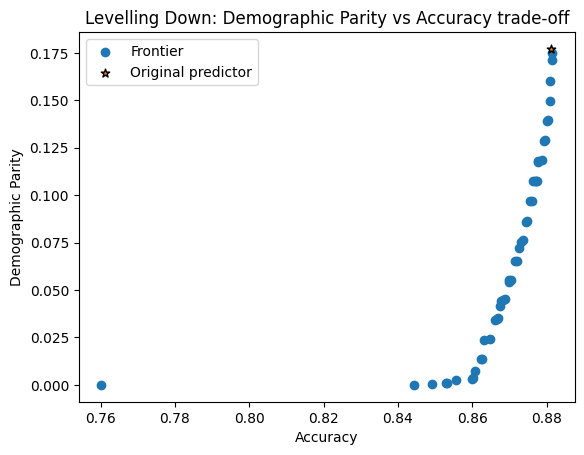

In [34]:
# Plot the accuracy/demographic trade-off
# This shows the expected behavior -- there is a smooth trade-off between accuracy and fairness,
# and then a sudden jump to the constant classifier which is perfectly fair.

fpredictor.plot_frontier(objective1=gm.demographic_parity,objective2=gm.accuracy, show_updated=False)
plt.title('Levelling Down: Demographic Parity vs Accuracy trade-off')

We now look at the selection rates for men and for women.

What we see is the expected behaviour. A steady trend where the selection rate decrease for one group, and increases for the other, overlayed with jitter caused by quantize artifacts. 

The overall pattern is that while for one group we see a potentially desirable trade-off where the selection rate increases at the cost of accuracy, for the other group we see undesirable behaviour where while accuracy also decreases the selection rate also decreases.

If the selection rate corresponds to, for example, offers for loans or scholarships, both forms of decrease are undesirable, and unneeded for the second group.

We can avoid them by levelling-up

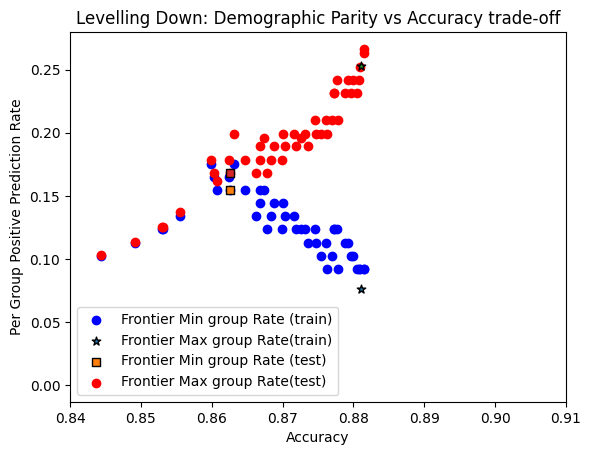

In [35]:
#Plot an overlay of the selection rate for each group as we vary the accuracy/demographic parity trade-off
fpredictor.plot_frontier(objective1=gm.pos_pred_rate.min,objective2=gm.accuracy, color='blue')
fpredictor.plot_frontier(objective1=gm.pos_pred_rate.max,objective2=gm.accuracy,new_plot=False,color='red')
# uncomment the following two lines to additionally plot on test data
#fpredictor.plot_frontier(test_data,objective1=gm.pos_pred_rate.min,objective2=gm.accuracy,new_plot=False, color='brown')
#fpredictor.plot_frontier(test_data,objective1=gm.pos_pred_rate.max,objective2=gm.accuracy,new_plot=False,color='pink')
plt.xlim(0.84,0.91)
plt.title('Levelling Down: Demographic Parity vs Accuracy trade-off')
plt.ylabel('Per Group Positive Prediction Rate')
plt.legend(('Frontier Min group Rate (train)', 'Frontier Max group Rate(train)',
            'Frontier Min group Rate (test)', 'Frontier Max group Rate(test)'))

Instead of enforcing fairness we can simply decide on a minimal selection rate for every group.

In [36]:
#Contrast with `Leveling-up' and enforcing a minimum selection rate for each group
fpredictor.fit(gm.accuracy,gm.pos_pred_rate.min,0.275,grid_width=grid_width)

Text(0.5, 1.0, 'Levelling Up: Minimum Positive Prediction Rate vs Accuracy trade-off')

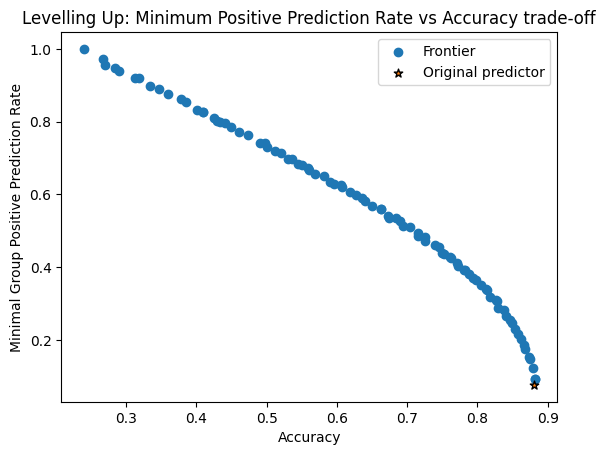

In [37]:
#Plot the new frontier
fpredictor.plot_frontier(objective1=gm.pos_pred_rate.min,objective2=gm.accuracy, show_updated=False)
plt.title('Levelling Up: Minimum Positive Prediction Rate vs Accuracy trade-off')

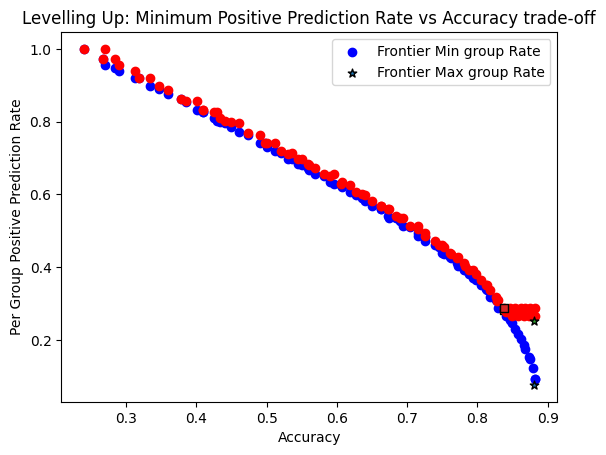

In [23]:
#Plot the new frontier for each group
fpredictor.plot_frontier(objective1=gm.pos_pred_rate.min,objective2=gm.accuracy, color='blue')
fpredictor.plot_frontier(objective1=gm.pos_pred_rate.max,objective2=gm.accuracy,new_plot=False,color='red')
plt.title('Levelling Up: Minimum Positive Prediction Rate vs Accuracy trade-off')
plt.ylabel('Per Group Positive Prediction Rate')
plt.legend(('Frontier Min group Rate', 'Frontier Max group Rate',))

We now plot demographic parity vs accuracy as we enforce minimal rate constraints.

As expected you see the unfairness decrease to near zero and then flatten out. This is overlayed by the same quantization noise as before causing the jittering effect.

Text(0.5, 1.0, 'Levelling Up: Minimum Positive Prediction Rate vs Accuracy trade-off')

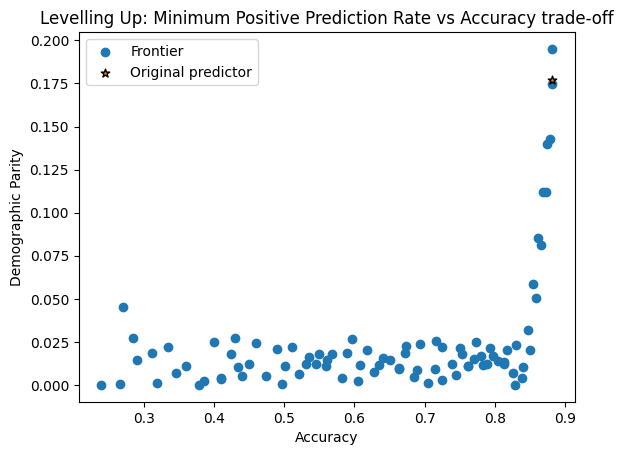

In [24]:
#Plot the new frontier with respect to demographic parity
fpredictor.plot_frontier(objective1=gm.demographic_parity,objective2=gm.accuracy, show_updated=False)
plt.title('Levelling Up: Minimum Positive Prediction Rate vs Accuracy trade-off')


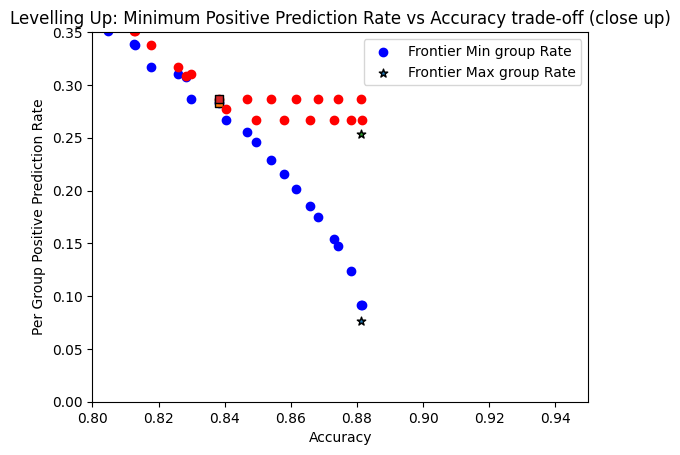

In [25]:
# Plot a detail of the behaviour of the frontier with respect to each group
fpredictor.plot_frontier(objective1=gm.pos_pred_rate.min,objective2=gm.accuracy, color='blue')
fpredictor.plot_frontier(objective1=gm.pos_pred_rate.max,objective2=gm.accuracy,new_plot=False,color='red')
plt.ylim(0,0.35)
plt.xlim(0.8,0.95)
plt.title('Levelling Up: Minimum Positive Prediction Rate vs Accuracy trade-off (close up)')
plt.ylabel('Per Group Positive Prediction Rate')
plt.legend(('Frontier Min group Rate','Frontier Max group Rate',))

In [26]:
#Do the same thing but for true negative difference. This fairness measure is analgous to equal opportunity but with the target label flipped.
fpredictor = FairPredictor(predictor,train_data,'sex')
# Maximize accuracy while enforcing that the equal opportunity (the difference in recall rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy,gm.true_neg_rate.diff,0.02,grid_width=grid_width)

Text(0.5, 1.0, 'Levelling Down: Difference in True Negative Rate vs Accuracy trade-off')

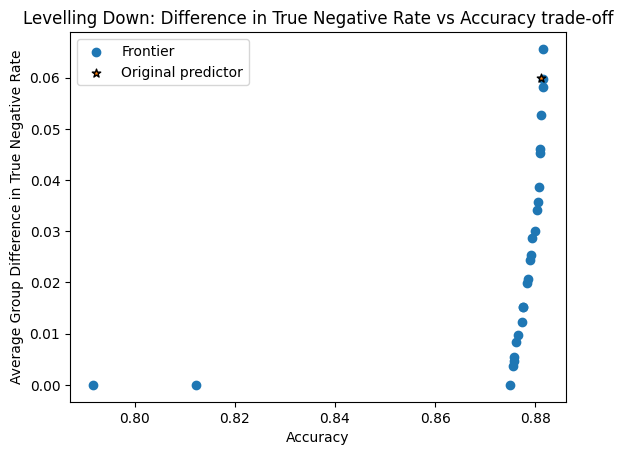

In [27]:
#plot the accuracy/true negative rate trade-off
import matplotlib.pyplot as plt
fpredictor.plot_frontier(objective1=gm.true_neg_rate.diff,objective2=gm.accuracy, show_updated=False)
plt.title('Levelling Down: Difference in True Negative Rate vs Accuracy trade-off')


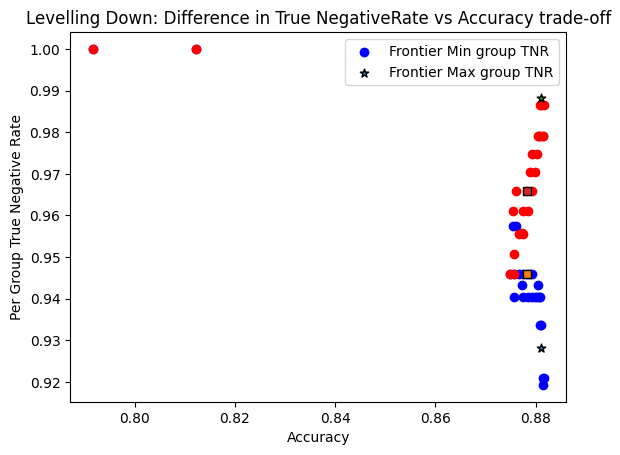

In [28]:
# plot the trade-off for each group
fpredictor.plot_frontier(objective1=gm.true_neg_rate.min,objective2=gm.accuracy, color='blue')
fpredictor.plot_frontier(objective1=gm.true_neg_rate.max,objective2=gm.accuracy,new_plot=False,color='red')
#plt.xlim(0.89,0.91)
#plt.ylim(0.8,1)
plt.title('Levelling Down: Difference in True NegativeRate vs Accuracy trade-off')
plt.ylabel('Per Group True Negative Rate')
plt.legend(('Frontier Min group TNR','Frontier Max group TNR',))

In [29]:
#Instead perform levelling up, by increasing the minimal true negative rate per group
fpredictor.fit(gm.accuracy,gm.true_neg_rate.min,0.99,grid_width=grid_width)

Text(0.5, 1.0, 'Levelling Up: Minimum True NegativeRate vs Accuracy trade-off')

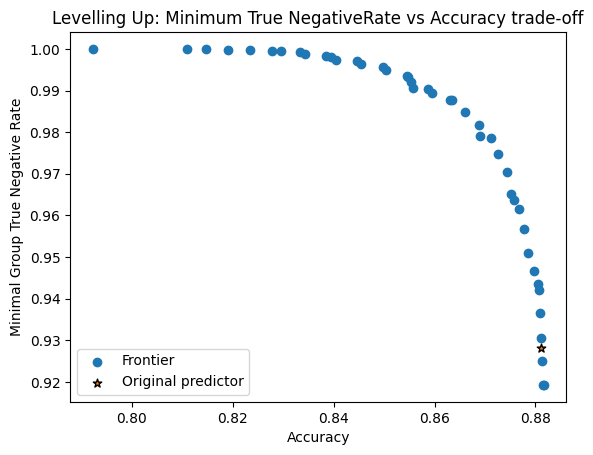

In [30]:
#plot
fpredictor.plot_frontier(objective1=gm.true_neg_rate.min,objective2=gm.accuracy, show_updated=False)
plt.title('Levelling Up: Minimum True NegativeRate vs Accuracy trade-off')


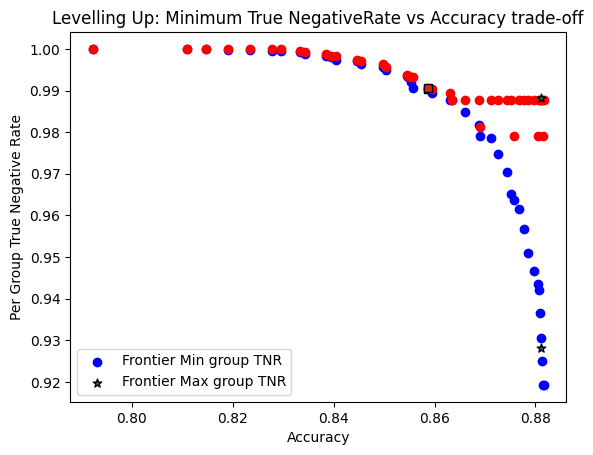

In [31]:
#Plot per group trade-off
fpredictor.plot_frontier(objective1=gm.true_neg_rate.min,objective2=gm.accuracy, color='blue')
fpredictor.plot_frontier(objective1=gm.true_neg_rate.max,objective2=gm.accuracy,new_plot=False,color='red')
plt.title('Levelling Up: Minimum True NegativeRate vs Accuracy trade-off')
plt.ylabel('Per Group True Negative Rate')
plt.legend(('Frontier Min group TNR','Frontier Max group TNR'))

Text(0.5, 1.0, 'Levelling Up: Minimum True NegativeRate vs Accuracy trade-off')

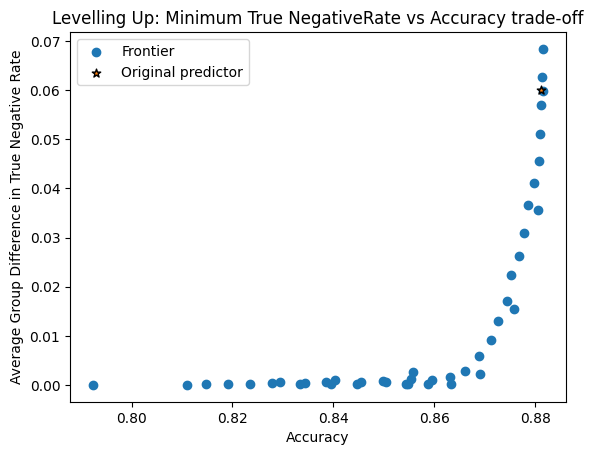

In [32]:
#Plot difference in true negative rate vs accuracy for the new pareto frontier
fpredictor.plot_frontier(objective1=gm.true_neg_rate.diff,objective2=gm.accuracy, show_updated=False)
plt.title('Levelling Up: Minimum True NegativeRate vs Accuracy trade-off')


Finally, we show that you can prevent levelling down by using the constraint `force_levelling_up='+'` when you call fit.

We enforce demographic parity using this constraint.

The curves we see are a subset of those generated by enforcing a minimal selection rate.

The curve shows a steady increase in the minimal selection rate until approximate demographic parity occurs, then there is a jump to the constant classifier that gives everyone a positive decision, which is perfectly fair.

The behavior can be somewhat unpredictable, and you can see the selection rate increasing for all groups, rather than just those with lower selection rates, if this causes a small improvement in fairness. Again this is due to quantization artifacts.

In [38]:
#Now we illustrate forced levelling-up. We do not allow offsets to decrease the selection rate.
fpredictor_up = FairPredictor(predictor, train_data, 'sex')
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor_up.fit(gm.accuracy, gm.demographic_parity, 0.02, grid_width=grid_width, force_levelling_up='+')

Text(0.5, 1.0, 'Forced levelling-up: Demographic Parity vs Accuracy trade-off')

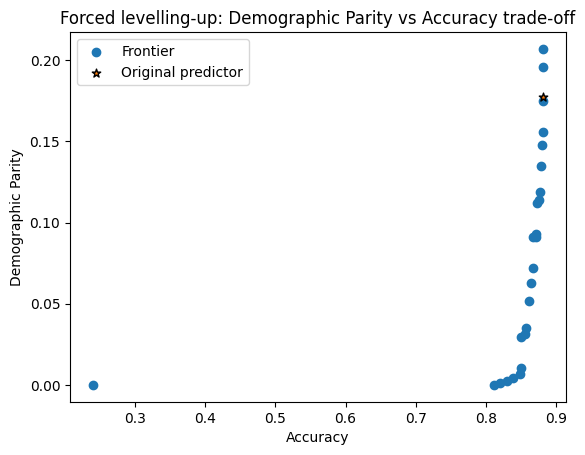

In [40]:
fpredictor_up.plot_frontier(objective1=gm.demographic_parity,objective2=gm.accuracy, show_updated=False)
plt.title('Forced levelling-up: Demographic Parity vs Accuracy trade-off')

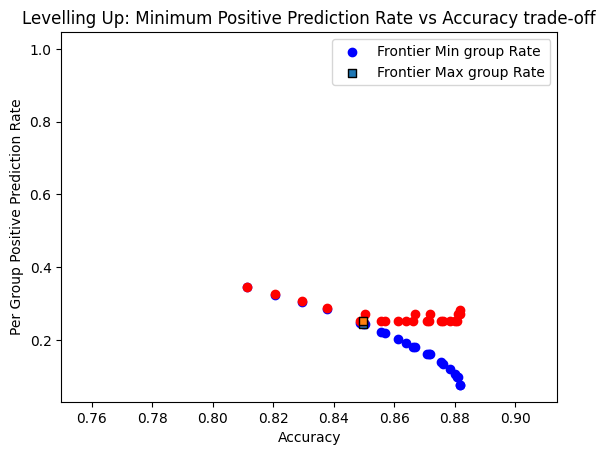

In [43]:
fpredictor_up.plot_frontier(objective1=gm.pos_pred_rate.min,objective2=gm.accuracy, color='blue',show_original=False)
fpredictor_up.plot_frontier(objective1=gm.pos_pred_rate.max,objective2=gm.accuracy,new_plot=False,color='red',show_original=False)
plt.xlim(left=0.75)
plt.title('Levelling Up: Minimum Positive Prediction Rate vs Accuracy trade-off')
plt.ylabel('Per Group Positive Prediction Rate')
plt.legend(('Frontier Min group Rate', 'Frontier Max group Rate',))

The same can also be done using `force_levelling_up='-'` if you want to decrease the selection rate.

This is useful for preventing levelling down when enforcing equality of precision or specificity (which are monotone decreasing with respect to the selection rate). 

Text(0.5, 1.0, 'Forced levelling-up: Equal Specificity vs Accuracy trade-off')

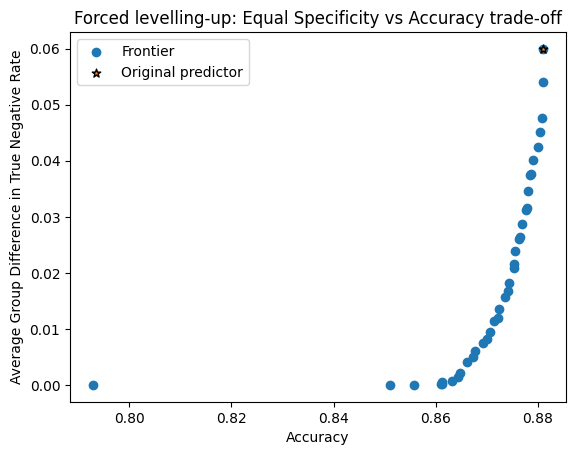

In [46]:
fpredictor_up.fit(gm.accuracy,gm.true_neg_rate.diff,0.02,grid_width=grid_width,force_levelling_up='-')
fpredictor_up.plot_frontier(objective1=gm.true_neg_rate.diff,objective2=gm.accuracy, show_updated=False)
plt.title('Forced levelling-up: Equal Specificity vs Accuracy trade-off')

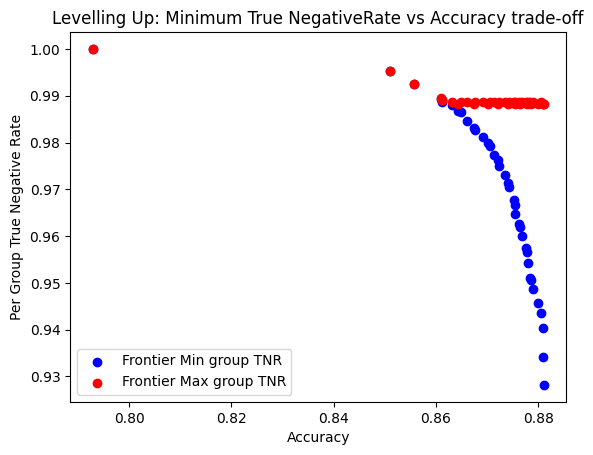

In [50]:
fpredictor_up.plot_frontier(objective1=gm.true_neg_rate.min,objective2=gm.accuracy, color='blue',show_original=False,show_updated=False)
fpredictor_up.plot_frontier(objective1=gm.true_neg_rate.max,objective2=gm.accuracy,new_plot=False,color='red',show_original=False,show_updated=False)
plt.title('Levelling Up: Minimum True NegativeRate vs Accuracy trade-off')
plt.ylabel('Per Group True Negative Rate')
plt.legend(('Frontier Min group TNR','Frontier Max group TNR'))